In [38]:
import os, time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pyDOE import lhs

import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

Los datos t, x se normalizan despues de calcular algo a al salida, si depende de esas entadas, como por ejemplo en la condicion inicial. Primero pasar por la función de la condicion inicial, los valores de t y x en el dominio original, despues normalizamos tx. Revisar para el resto.

In [39]:
ROOT = os.getcwd()
data = sp.io.loadmat(ROOT + '/NLS.mat')

In [40]:
def getIC(n: int=50):
    # Initial condition
    # t in [0, T] -> t in [-1, 1], T=pi/2
    # so that t = -1 is the initial condition
    # x in [a, b] -> x in [-1, 1], a=-5, b=5
    t = -1 * np.ones((n, 1))
    x = 10* lhs(1, n) - 5
    tx = np.concatenate((t, x), axis=1)
    u0 = 2 * (1 / np.cosh(x))
    v0 = np.zeros_like(x)
    uv0 = np.concatenate((u0, v0), axis=1)

    # Normalize x vector
    tx[:, 1] /= 5 

    return tx, uv0

def getBC(n: int=50):
    # Boundary conditions
    # x = {-1, 1}, for each boundary
    # t in [0, T] -> t in [-1, 1], so that t = 1 is the final condition
    t = 2 * lhs(1, n) - 1
    x_left = -1 * np.ones((n, 1))
    x_right = np.ones((n, 1))
    tx_left = np.concatenate((t, x_left), axis=1)
    tx_right = np.concatenate((t, x_right), axis=1)

    return tx_left, tx_right

def getCollocationPoints(n: int=50):
    return 2 * lhs(2, n) - 1

In [41]:
class Unsupervised(Dataset):
    def __init__(self, inputs):
        self.inputs = inputs
    
    def __len__(self):
        return self.inputs.shape[0]
    
    def __getitem__(self, idx):
        return self.inputs[idx]
    
class UnsupervisedDM(pl.LightningDataModule):
    def __init__(self, tx: np.ndarray, batch_size: int=32):
        super().__init__()
        self.n = tx.shape[0]
        self.tx = torch.tensor(tx, dtype=torch.float32, requires_grad=True)
        self.batch_size = batch_size
    
    def setup(self, stage: str=None, percent: float=0.9):
        indices = np.random.permutation(self.n)
        idx_lim = int(percent * self.n)
        # Get the indices for the train, validation and test sets
        train_idx = indices[0:idx_lim]
        val_idx = indices[idx_lim:]
        # Split the data into train, validation and test
        self.tx_train = self.tx[train_idx]
        self.tx_val = self.tx[val_idx]
    
    def getTrainDataloader(self):
        train_split = Unsupervised(self.tx_train)
        return DataLoader(train_split, batch_size=self.batch_size, shuffle=True)

    def getValDataloader(self):
        val_split = Unsupervised(self.tx_val)
        return DataLoader(val_split, batch_size=self.batch_size)

In [42]:
class Supervised(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
    
    def __len__(self):
        return self.inputs.shape[0]
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]
    
class SupervisedDM(pl.LightningDataModule):
    def __init__(self, tx: np.ndarray, uv: np.ndarray, batch_size: int=32):
        super().__init__()
        self.n = tx.shape[0]
        self.tx = torch.tensor(tx, dtype=torch.float32, requires_grad=True)
        self.uv = torch.tensor(uv, dtype=torch.float32)
        self.batch_size = batch_size
    
    def setup(self, stage: str=None, percent: float=0.9):
        indices = np.random.permutation(self.n)
        idx_lim = int(percent * self.n)
        # Get the indices for the train, validation and test sets
        train_idx = indices[0:idx_lim]
        val_idx = indices[idx_lim:]
        # Split the data into train, validation and test
        self.tx_train = self.tx[train_idx]
        self.tx_val = self.tx[val_idx]
        # Split the labels into train, validation and test
        self.uv_train = self.uv[train_idx]
        self.uv_val = self.uv[val_idx]
    
    def getTrainDataloader(self):
        train_split = Supervised(self.tx_train, self.uv_train)
        return DataLoader(train_split, batch_size=self.batch_size, shuffle=True)

    def getValDataloader(self):
        val_split = Supervised(self.tx_val, self.uv_val)
        return DataLoader(val_split, batch_size=self.batch_size)

In [43]:
def getICDataLoader(n: int=1000, batch_size: int=32):
    tx, uv = getIC(n)
    dataset = SupervisedDM(tx, uv, batch_size=batch_size)
    dataset.setup()
    train_dl = dataset.getTrainDataloader()
    val_dl = dataset.getValDataloader()
    return (train_dl, val_dl)

def getBCDataLoader(n: int=1000, batch_size: int=32):
    tx_left, tx_right = getBC(n)
    # Left boundary condition
    dataset_left = UnsupervisedDM(tx_left, batch_size=batch_size)
    dataset_left.setup()
    train_dl_left = dataset_left.getTrainDataloader()
    val_dl_left = dataset_left.getValDataloader()
    # Right boundary condition
    dataset_right = UnsupervisedDM(tx_right, batch_size=batch_size)
    dataset_right.setup()
    train_dl_right = dataset_right.getTrainDataloader()
    val_dl_right = dataset_right.getValDataloader()
    return (train_dl_left, val_dl_left, train_dl_right, val_dl_right)

def getDomainDataLoader(n: int=1000, batch_size: int=32):
    tx = getCollocationPoints(n)
    dataset = UnsupervisedDM(tx, batch_size=batch_size)
    dataset.setup()
    train_dl = dataset.getTrainDataloader()
    val_dl = dataset.getValDataloader()
    return (train_dl, val_dl)

def getDataDataLoader(n: int=1000, batch_size: int=32):
    # Extract t, x, u, v
    t = data['tt'].T
    x = data['x'].T
    u = np.real(data['uu']).T
    v = np.imag(data['uu']).T

    # Lower and upper bounds
    x_min, x_max = -5, 5
    t_min, t_max = 0, np.pi/2

    # Domain
    T, X = np.meshgrid(t, x, indexing='ij')
    tx = np.hstack((T.flatten()[:, None], X.flatten()[:, None]))
    uv = np.hstack((u.flatten()[:, None], v.flatten()[:, None]))

    # Normalize the domain
    tx[:, 0] = 2*(tx[:, 0] - t_min) / (t_max - t_min) - 1
    tx[:, 1] = 2*(tx[:, 1] - x_min) / (x_max - x_min) - 1

    # Randomly sample n points from the domain
    idx = np.random.choice(tx.shape[0], n, replace=False)
    tx = tx[idx, :]
    uv = uv[idx, :]

    # Create the data loader
    dataset = SupervisedDM(tx, uv, batch_size=batch_size)
    dataset.setup()
    train_dl = dataset.getTrainDataloader()
    val_dl = dataset.getValDataloader()
    return (train_dl, val_dl)

In [44]:
class SchrodingerPINN(nn.Module):
    def __init__(
            self, 
            sizes: list, 
            activations: list,
            loss_fn = nn.MSELoss(),  
            init_type: str='xavier', 
            device: str='cpu',
    ):
        super(SchrodingerPINN, self).__init__()
        self.sizes = sizes
        self.num_layers = len(sizes)
        self.loss_fn = loss_fn
        self.device = device

        # Define the layers.
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < len(activations):
                layers.append(activations[i])
        self.layers = nn.Sequential(*layers)

        # Initialize the parameters.
        if init_type is not None:
            self.initialize_weights(init_type)

        # Define the metrics.
        self.metrics = {
            'epochs': [], 
            'loss': {
                'train': {'ic': [], 'bc': [], 'domain': [], 'data': [], 'total': []}, 
                'eval' : {'ic': [], 'bc': [], 'domain': [], 'data': [], 'total': []}
            }, 
            'time': 0.0
        }

    def forward(self, xy):
        return self.layers(xy)
    
    def initialize_weights(self, init_type):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                if init_type == 'xavier':
                    nn.init.xavier_uniform_(layer.weight)
                elif init_type == 'he':
                    nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                elif init_type == 'normal':
                    nn.init.normal_(layer.weight, mean=0, std=0.01)
                if layer.bias is not None:
                    nn.init.uniform_(layer.bias, a=0, b=1)

    def computeSupervisedLoss(self, input_batch, target_batch):
        input_batch = input_batch.to(self.device)
        target_batch = target_batch.to(self.device)
        predict_batch = self.forward(input_batch)
        loss = self.loss_fn(predict_batch, target_batch)
        return loss
    
    def computeBCsLoss(self, tx_left_batch, tx_right_batch):
        tx_left_batch = tx_left_batch.to(self.device)
        tx_right_batch = tx_right_batch.to(self.device)
        uv_left = self.forward(tx_left_batch)
        uv_right = self.forward(tx_right_batch)
        u_left, v_left = uv_left[:, 0:1], uv_left[:, 1:2]
        u_right, v_right = uv_right[:, 0:1], uv_right[:, 1:2]

        # Compute 1st order derivatives
        u_x_left = torch.autograd.grad(u_left, tx_left_batch, torch.ones_like(u_left), create_graph=True)[0][:, 1:2]
        v_x_left = torch.autograd.grad(v_left, tx_left_batch, torch.ones_like(v_left), create_graph=True)[0][:, 1:2]
        u_x_right = torch.autograd.grad(u_right, tx_right_batch, torch.ones_like(u_right), create_graph=True)[0][:, 1:2]
        v_x_right = torch.autograd.grad(v_right, tx_right_batch, torch.ones_like(v_right), create_graph=True)[0][:, 1:2]

        # Compute the boundary loss
        loss = self.loss_fn(u_left, u_right)
        loss += self.loss_fn(v_left, v_right)
        loss += self.loss_fn(u_x_left, u_x_right)
        loss += self.loss_fn(v_x_left, v_x_right)
        return loss
    
    def computePDELoss(self, tx_batch):
        tx_batch = tx_batch.to(self.device)
        t, x = tx_batch[:, 0:1], tx_batch[:, 1:2]
        uv = self.forward(tx_batch)
        u, v = uv[:, 0:1], uv[:, 1:2]

        # Compute 1st order derivatives
        u_tx = torch.autograd.grad(u, tx_batch, torch.ones_like(u), create_graph=True)[0]
        v_tx = torch.autograd.grad(v, tx_batch, torch.ones_like(v), create_graph=True)[0]
        u_t, v_t = u_tx[:, 0:1], v_tx[:, 0:1]
        u_x, v_x = u_tx[:, 1:2], v_tx[:, 1:2]

        # Compute 2nd order derivatives
        u_xx = torch.autograd.grad(u_x, tx_batch, torch.ones_like(u_x), create_graph=True)[0][:, 1:2]
        v_xx = torch.autograd.grad(v_x, tx_batch, torch.ones_like(v_x), create_graph=True)[0][:, 1:2]

        # Compute the PDE residual
        fu = -v_t + 0.5 * u_xx + torch.sum(uv**2, dim=1) * u
        fv =  u_t + 0.5 * v_xx + torch.sum(uv**2, dim=1) * v
        loss  = self.loss_fn(fu, torch.zeros_like(fu))
        loss += self.loss_fn(fv, torch.zeros_like(fv))

        return loss
    
    def computeLoss(self, ic_dl, bc_left_dl, bc_right_dl, domain_dl, data_dl=None):
        # Compute initial condition loss
        ic_loss = 0.0
        for tx_batch, uv_batch in ic_dl:
            ic_loss += self.computeSupervisedLoss(tx_batch, uv_batch).item()
        
        # Compute boundary condition loss
        bc_loss = 0.0
        for tx_left_batch, tx_right_batch in zip(bc_left_dl, bc_right_dl):
            bc_loss += self.computeBCsLoss(tx_left_batch, tx_right_batch).item()
        
        # Compute domain loss
        domain_loss = 0.0
        for tx_batch in domain_dl:
            domain_loss += self.computePDELoss(tx_batch).item()

        # Compute data loss
        data_loss = 0.0
        if data_dl:
            for tx_batch, uv_batch in data_dl:
                data_loss += self.computeSupervisedLoss(tx_batch, uv_batch).item()
        
        # Compute total loss
        total_loss = ic_loss + bc_loss + domain_loss + data_loss

        # Normalize the losses
        ic_loss /= len(ic_dl)
        bc_loss /= len(bc_left_dl)
        domain_loss /= len(domain_dl)
        data_loss /= len(data_dl) if data_dl else 1.0

        return ic_loss, bc_loss, domain_loss, data_loss, total_loss
    
    def trainBatch(self, ic_batch, bc_left_batch, bc_right_batch, domain_batch, optimizer, data_batch=None):
        tx0_batch, uv0_batch = ic_batch
        loss_ic = self.computeSupervisedLoss(tx0_batch, uv0_batch)
        loss_bc = self.computeBCsLoss(bc_left_batch, bc_right_batch)
        loss_domain = self.computePDELoss(domain_batch)
        if data_batch:
            tx_batch, uv_batch = data_batch
            loss_data = self.computeSupervisedLoss(tx_batch, uv_batch)
            loss = loss_ic + loss_bc + loss_domain + loss_data
        else:
            loss_data = torch.tensor(0.0)
            loss = loss_ic + loss_bc + loss_domain
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        return loss_ic.item(), loss_bc.item(), loss_domain.item(), loss_data.item(), loss.item()
    
    def fit(self, train_dataloader, optimizer=optim.Adam, epochs=30, lr=1e-4, 
        regularization=0.0, eval_dataloader=None, verbose=True, epch_print=1):

        # Set the starting epoch
        last_epoch = self.metrics['epochs'][-1] if self.metrics['epochs'] else 0
        starting_epoch = last_epoch + 1
    
        # Get the dataloaders
        ic_train_dl, bc_left_train_dl, bc_right_train_dl, domain_train_dl, data_train_dl = train_dataloader
        ic_eval_dl, bc_left_eval_dl, bc_right_eval_dl, domain_eval_dl, data_eval_dl = eval_dataloader
        optimizer = optimizer(self.parameters(), lr=lr, weight_decay=regularization)

        # Start the training
        start_time = time.time()
        for i in range(epochs):
            self.train()
            train_loss_ic, train_loss_bc, train_loss_domain, train_loss_data, train_loss = 0.0, 0.0, 0.0, 0.0, 0.0
            if data_train_dl:
                for ic_batch, left_batch, right_batch, domain_batch, data_batch in zip(
                    ic_train_dl, bc_left_train_dl, bc_right_train_dl, domain_train_dl, data_train_dl):
                    loss_batch = self.trainBatch(ic_batch, left_batch, right_batch, domain_batch, optimizer, data_batch)
                    train_loss_ic += loss_batch[0]
                    train_loss_bc += loss_batch[1]
                    train_loss_domain += loss_batch[2]
                    train_loss_data += loss_batch[3]
                    train_loss += loss_batch[4]
            else:
                for ic_batch, left_batch, right_batch, domain_batch in zip(
                    ic_train_dl, bc_left_train_dl, bc_right_train_dl, domain_train_dl):
                    loss_batch = self.trainBatch(ic_batch, left_batch, right_batch, domain_batch, optimizer)
                    train_loss_ic += loss_batch[0]
                    train_loss_bc += loss_batch[1]
                    train_loss_domain += loss_batch[2]
                    train_loss += loss_batch[4]
            
            # Normalize the losses
            train_loss_ic /= len(ic_train_dl)
            train_loss_bc /= len(bc_left_train_dl)
            train_loss_domain /= len(domain_train_dl)
            train_loss_data /= len(data_train_dl) if data_train_dl else 1.0
            n = len(ic_train_dl) + len(bc_left_train_dl) + len(domain_train_dl)
            n += len(data_train_dl) if data_train_dl else 0
            train_loss /= n
            
            # Save training metrics
            self.metrics['epochs'].append(starting_epoch + i)
            self.metrics['loss']['train']['ic'].append(train_loss_ic)
            self.metrics['loss']['train']['bc'].append(train_loss_bc)
            self.metrics['loss']['train']['domain'].append(train_loss_domain)
            self.metrics['loss']['train']['data'].append(train_loss_data)
            self.metrics['loss']['train']['total'].append(train_loss)

            # Evaluate the model
            self.eval()
            if eval_dataloader:
                loss_batch = self.computeLoss(ic_eval_dl, bc_left_eval_dl, bc_right_eval_dl, domain_eval_dl, data_eval_dl)
                self.metrics['loss']['eval']['ic'].append(loss_batch[0])
                self.metrics['loss']['eval']['bc'].append(loss_batch[1])
                self.metrics['loss']['eval']['domain'].append(loss_batch[2])
                self.metrics['loss']['eval']['data'].append(loss_batch[3])
                self.metrics['loss']['eval']['total'].append(loss_batch[4])
            
            # Print the progress
            if verbose and (i + 1) % epch_print == 0:
                eval_loss = loss_batch[2] if eval_dataloader else 'N/A'
                print(f"Epoch {i+1}/{epochs}: Loss ({train_loss:.4g}, {eval_loss:.4g})")

        self.metrics['time'] += time.time() - start_time
    
    def size(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def save(self, path: str="model_params.pth"):
        torch.save(self.state_dict(), path)

    def load(self, path: str="model_params.pth"):
        self.load_state_dict(torch.load(path))
        self.to(self.device)

In [45]:
ic_dl = getICDataLoader(n=50, batch_size=16)
bc_dl = getBCDataLoader(n=50, batch_size=16)
bc_left_dl = (bc_dl[0], bc_dl[1])
bc_right_dl = (bc_dl[2], bc_dl[3])
domain_dl = getDomainDataLoader(n=20000, batch_size=64)
data_dl = getDataDataLoader(n=1000, batch_size=32)

In [46]:
hn, hl = 100, 5
sizes = [2] + [hn] * hl + [2]
activations = [nn.Tanh()] * hl
model = SchrodingerPINN(sizes, activations)
model.to('cpu')

SchrodingerPINN(
  (loss_fn): MSELoss()
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): Tanh()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): Tanh()
    (10): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [47]:
train_dl = (ic_dl[0], bc_left_dl[0], bc_right_dl[0], domain_dl[0], data_dl[0])
eval_dl = (ic_dl[1], bc_left_dl[1], bc_right_dl[1], domain_dl[1], data_dl[1])
model.fit(train_dl, eval_dataloader=eval_dl, epochs=10000, lr=1e-4, verbose=True, epch_print=1000)

Epoch 1000/10000: Loss (0.004845, 0.01118)
Epoch 2000/10000: Loss (0.00443, 0.02713)
Epoch 3000/10000: Loss (0.006445, 0.03779)
Epoch 4000/10000: Loss (0.003524, 0.0279)
Epoch 5000/10000: Loss (0.004637, 0.03597)
Epoch 6000/10000: Loss (0.003392, 0.03161)
Epoch 7000/10000: Loss (0.004484, 0.03218)
Epoch 8000/10000: Loss (0.00499, 0.03759)
Epoch 9000/10000: Loss (0.004572, 0.03214)
Epoch 10000/10000: Loss (0.003477, 0.03545)


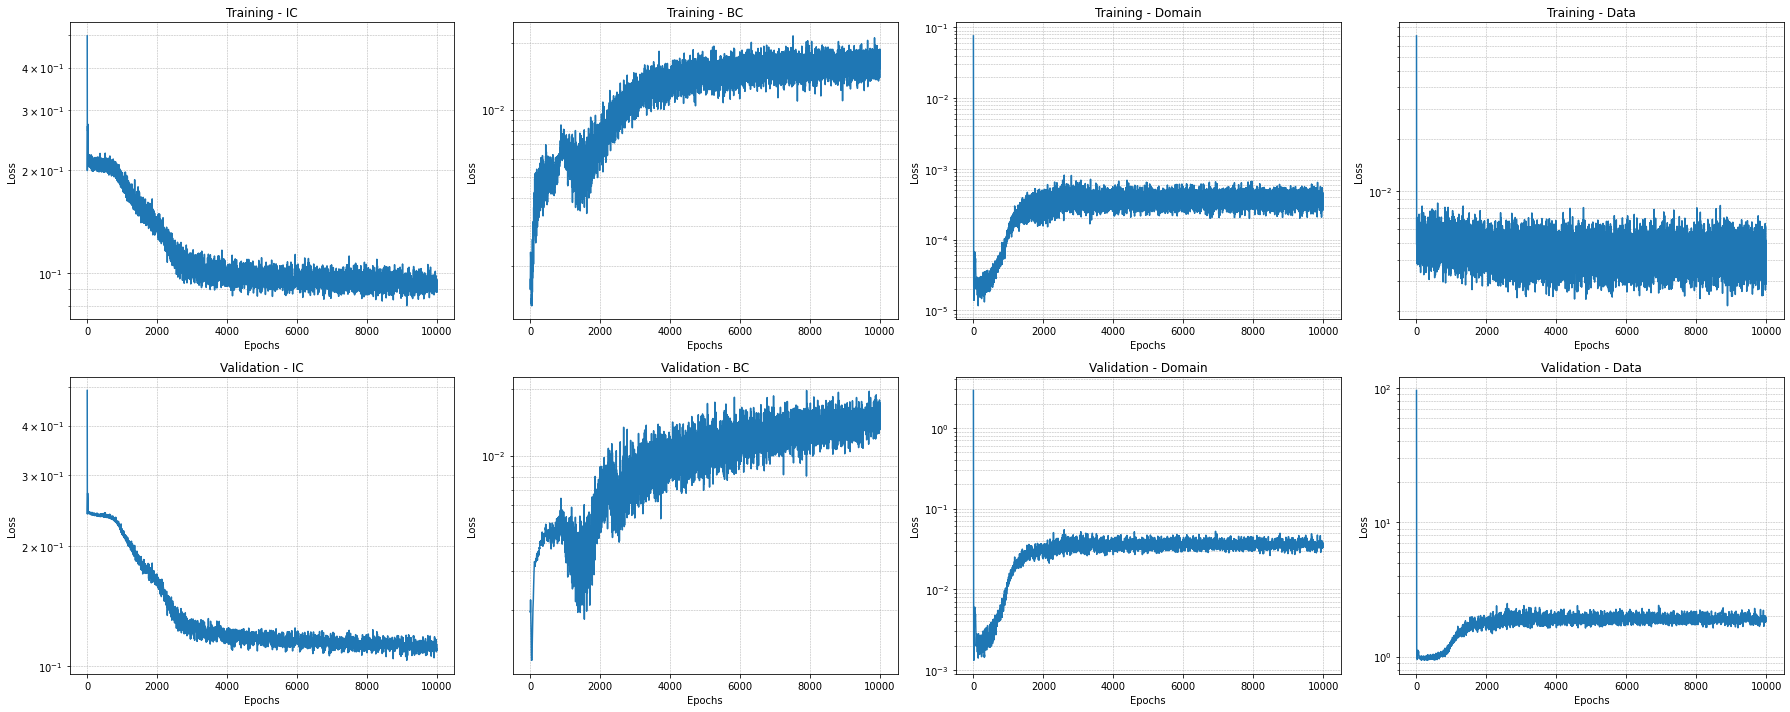

In [48]:
# Plot the results
fig, axs = plt.subplots(2, 4, figsize=(25, 10))

# Plot training loss: IC / BC / Domain / Total
axs[0][0].plot(model.metrics['epochs'], model.metrics['loss']['train']['ic'])
axs[0][1].plot(model.metrics['epochs'], model.metrics['loss']['train']['bc'])
axs[0][2].plot(model.metrics['epochs'], model.metrics['loss']['train']['domain'])
axs[0][3].plot(model.metrics['epochs'], model.metrics['loss']['train']['total'])

axs[0][0].set_title("Training - IC")
axs[0][1].set_title("Training - BC")
axs[0][2].set_title("Training - Domain")
axs[0][3].set_title("Training - Data")
for i in range(4):
    axs[0][i].set_xlabel("Epochs")
    axs[0][i].set_ylabel("Loss")
    axs[0][i].set_yscale('log')
    axs[0][i].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot training loss: IC / BC / Domain / Total
axs[1][0].plot(model.metrics['epochs'], model.metrics['loss']['eval']['ic'])
axs[1][1].plot(model.metrics['epochs'], model.metrics['loss']['eval']['bc'])
axs[1][2].plot(model.metrics['epochs'], model.metrics['loss']['eval']['domain'])
axs[1][3].plot(model.metrics['epochs'], model.metrics['loss']['eval']['total'])

axs[1][0].set_title("Validation - IC")
axs[1][1].set_title("Validation - BC")
axs[1][2].set_title("Validation - Domain")
axs[1][3].set_title("Validation - Data")
for i in range(4):
    axs[1][i].set_xlabel("Epochs")
    axs[1][i].set_ylabel("Loss")
    axs[1][i].set_yscale('log')
    axs[1][i].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig(f"loss_{hn}n.png", dpi=300, facecolor='w', edgecolor='w')
plt.show()

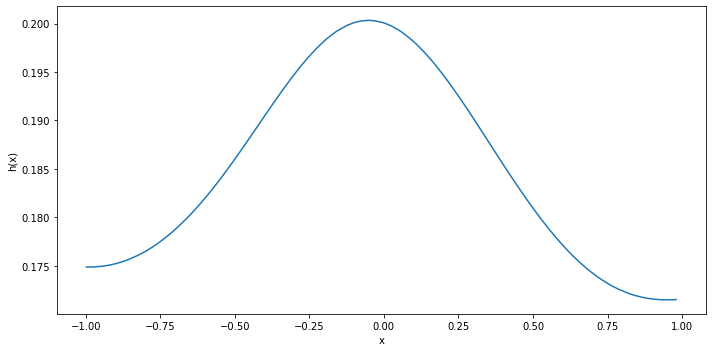

In [54]:
# Predict the solution at t = 0.59
n = 100
t = (2 * 0.59 - 1) * np.ones((n, 1))
x = 2 * lhs(1, n) - 1
x = np.sort(x, axis=0)
tx = np.concatenate((t, x), axis=1)
tx = torch.tensor(tx, dtype=torch.float32)
uv = model(tx).detach().numpy()
h = np.sum(uv**2, axis=1)

# Plot the solution
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(x, h)
ax.set_xlabel('x')
ax.set_ylabel('h(x)')
plt.tight_layout()
plt.show()

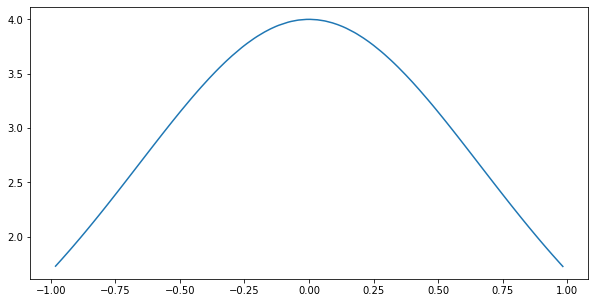

In [51]:
ic_tx_uv = getIC(n=100)
ic_tx, ic_uv = ic_tx_uv
ic_h = np.sum(ic_uv**2, axis=1)

# sort the initial condition
idx = np.argsort(ic_tx[:, 1])
ic_tx = ic_tx[idx, :]
ic_h = ic_h[idx]

# plot the initial condition
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(ic_tx[:, 1], ic_h)


In [ ]:
class PINN(nn.Module):
    
    def __init__(
            self, 
            sizes: list, 
            activations: list,
            loss_fn = nn.MSELoss(),  
            init_type: str='normal', 
            device: str='cpu'
    ):
        super(PINN, self).__init__()
        self.sizes = sizes
        self.num_layers = len(sizes)
        self.loss_fn = loss_fn
        self.device = device

        # Define the layers of the network
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < len(activations):
                layers.append(activations[i])
        self.layers = nn.Sequential(*layers)

        # Initialize the weights of the network
        if init_type is not None:
            self.initialize_weights(init_type)
        
    def forward(self, tx):
        return self.layers(tx)
    
    def initialize_weights(self, init_type):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                if init_type == 'xavier':
                    nn.init.xavier_uniform_(layer.weight)
                elif init_type == 'he':
                    nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                elif init_type == 'normal':
                    nn.init.normal_(layer.weight, mean=0, std=0.01)
                if layer.bias is not None:
                    nn.init.uniform_(layer.bias, a=0, b=1)
    
    def trainBatch(self, ic_batch, bc_batch, domain_batch, optimizer):

        ic_tx, ic_uv = ic_batch
        bc_tx_lb, bc_tx_ub = bc_batch
        tx, uv = domain_batch

        loss = 0.0
        loss += self.computeICLoss(ic_tx, ic_uv)
        loss += self.computeBCLoss(bc_tx_lb, bc_tx_ub)
        loss += self.computeDomainLoss(tx, uv)
        loss += self.computeDataLoss(tx, uv)

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        return loss.item()
    
    def computeDataLoss(self, tx_batch, uv_batch):
        tx_batch = tx_batch.to(self.device)
        uv_batch = uv_batch.to(self.device)
        uv_pred_batch = self.forward(tx_batch)
        loss = self.loss_fn(uv_pred_batch, uv_batch)
        return loss

    def computeICLoss(self, tx_batch, uv_batch):
        tx_batch = tx_batch.to(self.device)
        uv_batch = uv_batch.to(self.device)
        uv_pred_batch = self.forward(tx_batch)
        loss = self.loss_fn(uv_pred_batch, uv_batch)
        return loss
    
    def computeBCLoss(self, tx_lb_batch, tx_ub_batch):
        tx_lb_batch = tx_lb_batch.to(self.device)
        tx_ub_batch = tx_ub_batch.to(self.device)
        uv_lb = self.forward(tx_lb_batch)
        uv_ub = self.forward(tx_ub_batch)
        # Extract the x, u, v values
        x_lb = tx_lb_batch[:, 1:2]
        x_ub = tx_ub_batch[:, 1:2]
        u_lb = uv_lb[:, 0:1]
        u_ub = uv_ub[:, 0:1]
        v_lb = uv_lb[:, 1:2]
        v_ub = uv_ub[:, 1:2]
        # Compute d/dx
        du_dx_lb = torch.autograd.grad(u_lb, x_lb, torch.ones_like(u_lb))[0]
        dv_dx_lb = torch.autograd.grad(v_lb, x_lb, torch.ones_like(v_lb))[0]
        du_dx_ub = torch.autograd.grad(u_ub, x_ub, torch.ones_like(u_ub))[0]
        dv_dx_ub = torch.autograd.grad(v_ub, x_ub, torch.ones_like(v_ub))[0]
        # Compute the boundary loss
        loss = self.loss_fn(uv_lb, uv_ub)
        loss += self.loss_fn(du_dx_lb, du_dx_ub)
        loss += self.loss_fn(dv_dx_lb, dv_dx_ub)

        return loss
    
    def computeDomainLoss(self, tx_batch, uv_batch):
        tx_batch = tx_batch.to(self.device)
        uv_batch = uv_batch.to(self.device)
        uv = self.forward(tx_batch)
        x = tx_batch[:, 1]
        u = uv[:, 0]
        v = uv[:, 1]

        ## Compute the gradients (d/dt, d/dx)
        du_dtx = torch.autograd.grad(u, tx_batch, torch.ones_like(u), create_graph=True)[0]
        dv_dtx = torch.autograd.grad(v, tx_batch, torch.ones_like(v), create_graph=True)[0]

        ## Compute the second derivatives (d^2/dx^2)
        d2u_dx2 = torch.autograd.grad(du_dtx[:, 1], x, torch.ones_like(du_dtx[:, 1]), create_graph=True, allow_unused=True)[0]
        d2v_dx2 = torch.autograd.grad(dv_dtx[:, 1], x, torch.ones_like(dv_dtx[:, 1]), create_graph=True, allow_unused=True)[0]

        ## Compute the PDE loss
        f_u = -dv_dtx[:, 0] + 0.5 * d2u_dx2 + torch.sum(uv**2, dim=1) * u
        f_v =  du_dtx[:, 0] + 0.5 * d2v_dx2 + torch.sum(uv**2, dim=1) * v
        loss  = self.loss_fn(f_u, torch.zeros_like(f_u))
        loss += self.loss_fn(f_v, torch.zeros_like(f_v))
        
        return loss
    
    def computeLoss(self, ic_dl, bc_dl, domain_dl):
        loss = 0.0
        # Compute the loss for the initial condition
        ic_loss = 0.0
        for ic_tx_batch, ic_uv_batch in ic_dl:
            with torch.no_grad():
                ic_loss += self.computeICLoss(ic_tx_batch, ic_uv_batch).item()
        loss += ic_loss / len(ic_dl)
        # Compute the loss for the boundary condition
        bc_loss = 0.0
        for bc_tx_lb_batch, bc_tx_ub_batch in bc_dl:
            bc_loss += self.computeBCLoss(bc_tx_lb_batch, bc_tx_ub_batch).item()
        loss += bc_loss / len(bc_dl)
        # Compute the loss for the domain
        domain_loss = 0.0
        for tx_batch, uv_batch in domain_dl:
            domain_loss += self.computeDomainLoss(tx_batch, uv_batch).item()
        loss += domain_loss / len(domain_dl)
        # Compute data loss
        data_loss = 0.0
        for tx_batch, uv_batch in domain_dl:
            data_loss += self.computeDataLoss(tx_batch, uv_batch).item()
        loss += data_loss / len(domain_dl)
        return loss
    
    def predict(self, tx):
        return self.forward(tx)
    
    def fit(self, train_dataloader, optimizer=optim.Adam, epochs=30, lr=1e-4, 
        regularization=0.0, eval_dataloader=None, monitor=False, verbose=False, 
        epch_print=1):
    
        train_loss, eval_loss = [], []
        ic_train_dl, bc_train_dl, domain_train_dl = train_dataloader
        ic_eval_dl, bc_eval_dl, domain_eval_dl = eval_dataloader
        optimizer = optimizer(self.parameters(), lr=lr, weight_decay=regularization)

        start_time = time.time()
        for i in range(epochs):
            self.train()
            for ic_batch, bc_batch, domain_batch in zip(ic_train_dl, bc_train_dl, domain_train_dl):
                self.trainBatch(ic_batch, bc_batch, domain_batch, optimizer)
            
            # Set the model to evaluation mode
            self.eval()
            
            if monitor:
                train_loss_value = self.computeLoss(ic_train_dl, bc_train_dl, domain_train_dl)
                train_loss.append(train_loss_value)

                if eval_dataloader:
                    eval_loss_value = self.computeLoss(ic_eval_dl, bc_eval_dl, domain_eval_dl)
                    eval_loss.append(eval_loss_value)
                
            if verbose and (i + 1) % epch_print == 0:
                print("Epoch {:2d}/{}: Loss ({:.4g}, {:.4g})".format(
                    i + 1, epochs, train_loss[-1] if monitor else 'N/A', 
                    eval_loss[-1] if eval_dataloader else 'N/A'))

        elapsing_time = time.time() - start_time
        
        return train_loss, eval_loss, elapsing_time
    
    def size(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def save(self, path: str="model_params.pth"):
        torch.save(self.state_dict(), path)

    def load(self, path: str="model_params.pth"):
        self.load_state_dict(torch.load(path))
        self.to(self.device)

In [342]:
N0 = 50
ic = getInitialCondition(data, n=N0)
ic_dm = ICDataModule(ic[0], ic[1], batch_size=2)
ic_dm.setup()
ic_train_dl = ic_dm.train_dataloader()
ic_val_dl = ic_dm.val_dataloader()
ic_test_dl = ic_dm.test_dataloader()

In [343]:
Nb = 50
bc_lw, bc_up = getBoundayCondition(data, Nb)
bc_dm = BCDataModule(bc_lw, bc_up, batch_size=2)
bc_dm.setup()
bc_train_dl = bc_dm.train_dataloader()
bc_val_dl = bc_dm.val_dataloader()
bc_test_dl = bc_dm.test_dataloader()

In [344]:
Nf = 20000
domain = getDomain(data, n=Nf)
domain_dm = DomainDataModule(domain[0], domain[1], batch_size=32)
domain_dm.setup()
domain_train_dl = domain_dm.train_dataloader()
domain_val_dl = domain_dm.val_dataloader()
domain_test_dl = domain_dm.test_dataloader()

In [345]:
layers = [2, 100, 100, 100, 100, 100, 2]
activations = [nn.Tanh()] * (len(layers) - 2)
loss_fn = nn.MSELoss()
init_type = 'xavier'
device = 'cpu'

pinn = PINN(layers, activations, loss_fn, init_type, device)
pinn.to(device)

PINN(
  (loss_fn): MSELoss()
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): Tanh()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): Tanh()
    (10): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [346]:
in1 = torch.tensor([[0.0, 0.0], [0.1, 0.1], [0.2, 0.2]], dtype=torch.float32, requires_grad=True)
out1 = pinn.forward(in1)

In [347]:
out1

tensor([[ 1.3700, -0.1243],
        [ 1.3669, -0.1202],
        [ 1.3639, -0.1159]], grad_fn=<AddmmBackward0>)

In [348]:
out1_1 = out1[:,0].view(3,-1)
out1_1

tensor([[1.3700],
        [1.3669],
        [1.3639]], grad_fn=<ViewBackward0>)

In [349]:
grad1 = torch.autograd.grad(out1_1, in1, torch.ones_like(out1_1))[0]

In [350]:
grad1

tensor([[-0.0097, -0.0214],
        [-0.0090, -0.0217],
        [-0.0082, -0.0220]])

In [351]:
train_dataloader = (ic_train_dl, bc_train_dl, domain_train_dl)
eval_dataloader = (ic_val_dl, bc_val_dl, domain_val_dl)
metrics = pinn.fit(train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, 
                   epochs=5000, lr=1e-4, optimizer=optim.Adam, monitor=True, verbose=True, 
                   epch_print=25)

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [ ]:
# Plot loss and accuracy in the same figure sharing the x-axis
fig, ax1 = plt.subplots()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(metrics[0], 'b-', label='Train')
ax1.plot(metrics[1], 'b--', label='Validation')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='best')
ax1.grid(linewidth=0.5, linestyle='--', axis='both')
fig.tight_layout()
plt.show()

In [ ]:
# Predict solution for x = [-5, 5] at t=0.59
x = np.linspace(-1, 1, 100)
t = 0.59
t = np.ones(x.shape) * 2 * t / np.pi/2 - 1
tx = np.hstack((t[:, None], x[:, None]))
tx = torch.tensor(tx, dtype=torch.float32)
uv = pinn.predict(tx).detach().numpy()
h = np.sqrt(uv[:, 0]**2 + uv[:, 1]**2)

plt.figure(figsize=(10, 5))
plt.plot(x, h, 'r-', label='t=0')
plt.xlabel('x')
plt.ylabel('h')
plt.legend(loc='best')
plt.grid(linewidth=0.5, linestyle='--', axis='both')
plt.tight_layout()
plt.show()

In [ ]:
import torch

# Ejemplo inicial
n_samples = 3
n_features = 4
n_variables = 2

inputs = torch.randn(n_samples, n_features, requires_grad=True)
fc1 = torch.nn.Linear(n_features, n_variables, bias=True)
for param in fc1.parameters():
    param.requires_grad = True
outputs = fc1(inputs)

grad = torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

print(f"Input shape: {inputs.shape}")
print(f"Grad shape: {grad.shape}")
print(grad)
print("-" * 50)
print(f"Weight shape: {fc1.weight.shape}")
print(fc1.weight)
print(fc1.weight.sum(dim=0))
print("-" * 50)
print(f"Output shape: {outputs.shape}")
print(outputs)



In [355]:
import torch
import torch.nn as nn

# Ejemplo de red neuronal simple
class RedNeuronal(nn.Module):
    def __init__(self):
        super(RedNeuronal, self).__init__()
        self.fc = nn.Linear(2, 2)  # 2 entradas, 2 salidas

    def forward(self, x):
        return self.fc(x)

# Instanciamos la red y activamos requires_grad en las entradas
red = RedNeuronal()
entradas = torch.randn(10, 2, requires_grad=True)  # batch de 10 muestras, 2 entradas

# Hacemos forward pass
salidas = red(entradas)

# Calculamos las derivadas de las salidas respecto a las entradas
# torch.ones_like(salidas) se usa para indicar que queremos la derivada completa
gradientes = torch.autograd.grad(
    outputs=salidas,
    inputs=entradas,
    grad_outputs=torch.ones_like(salidas),
    retain_graph=True,  # Retenemos el gráfico si necesitamos más gradientes
    create_graph=True   # Creamos el gráfico para derivadas de orden superior si se necesitan
)

print("Gradientes de las salidas respecto a las entradas:", gradientes[0])

# Calculamos el jacobiano usando autograd.functional.jacobian
jacobiano = torch.autograd.functional.jacobian(red.forward, entradas)
print(jacobiano.shape)
print("Jacobiano de las salidas respecto a las entradas:", jacobiano)


Gradientes de las salidas respecto a las entradas: tensor([[-0.4024, -0.4405],
        [-0.4024, -0.4405],
        [-0.4024, -0.4405],
        [-0.4024, -0.4405],
        [-0.4024, -0.4405],
        [-0.4024, -0.4405],
        [-0.4024, -0.4405],
        [-0.4024, -0.4405],
        [-0.4024, -0.4405],
        [-0.4024, -0.4405]], grad_fn=<MmBackward0>)
torch.Size([10, 2, 10, 2])
Jacobiano de las salidas respecto a las entradas: tensor([[[[-0.0698,  0.0209],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],

         [[-0.3326, -0.4614],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.000

### Derivadas

Cuando tenemos que calcular las derivadas parciales de una funcion vectorial resepcto de sus variables $f(x_1, x_2, \ldots, x_n)$, usamos ``torch.autograd.grad``, ya que implica calcular la derivada de un escalar respecto de $n$ variables (es valido para un batch con samples). Sin embargo, cuando tenemos un campo vectorial, ya no puedo usar la misma función, porque falla cuando quiero extraer cada variable dependiente para hacer el calculo de derivadas, como que se ramifica el graph de los gradientes. En eset caso tengo que trabajar con ``torch.autograd.functional.jacobian``, la cual me permite aplicar lo mismo que ``autograd.grad`` pero para cada variable dependiente.